In [1]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
#Get Data
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
#Get all offspeed
os = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp', 'Splitter'])]
print(os.shape)

(31218, 167)


In [4]:
#Subset offspeed into platoon splits
os_rr = os[(os['PitcherThrows'] == 'Right') & (os['BatterSide'] == 'Right')]
os_rl = os[(os['PitcherThrows'] == 'Right') & (os['BatterSide'] == 'Left')]
os_lr = os[(os['PitcherThrows'] == 'Left') & (os['BatterSide'] == 'Right')]
os_ll = os[(os['PitcherThrows'] == 'Left') & (os['BatterSide'] == 'Left')]

print(os_rr.shape)
print(os_rl.shape)
print(os_lr.shape)
print(os_ll.shape)

(6194, 167)
(14470, 167)
(9513, 167)
(1019, 167)


In [5]:
#Whiffs
os_rr['whiff'] = np.where(os_rr['PitchCall']=='StrikeSwinging',1,0)
os_rl['whiff'] = np.where(os_rl['PitchCall']=='StrikeSwinging',1,0)
os_lr['whiff'] = np.where(os_lr['PitchCall']=='StrikeSwinging',1,0)
os_ll['whiff'] = np.where(os_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_2904\893311075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_rr['whiff'] = np.where(os_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_2904\893311075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_rl['whiff'] = np.where(os_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_2904\893311075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [6]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs. Righty Split

In [7]:
os_rr_X = os_rr[preds]
os_rr_y = os_rr['whiff']

In [8]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(os_rr_X, os_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.30%


ROC AUC: 0.5495


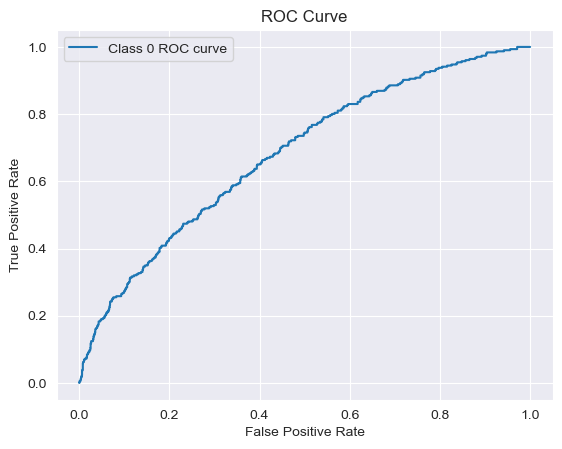

In [9]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [11]:
# Get unique values
unique_values = os_rr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_rr[os_rr['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Baley, Luke' 'Troesser, Austin' 'Jones, Burrell'
 'Cortez, Christopher' 'Matheny, Chase' 'Hunter, Aidan' 'Payne, Nate'
 'Crisp, Nolan' 'Polk, Michael' 'Cheeley, Austin ' 'Rustad, Carter'
 'Miller, Brady' 'Skenes, Paul' 'Levy, Gabe' 'Vega, Adrian' 'Cannon, Will'
 'Weirather, Brock' 'Corso, Vincent' 'Rodriguez, Esteben' 'Causey, AJ'
 'Peppers, Jake' 'Fagerstrom, Reid' 'Sanders, Will' 'Williams, Brendan'
 'Hicks, James' 'Rodgers, Zachary' 'Cota, Miles' 'Bogli, Shane'
 'Berg, Hayden' 'Parmer, Evan' 'Saunier, Grayson' 'Pizzico, Luke'
 'Rudis, Brad' 'Ey, Brooks' 'Gonzalez, Joseph' 'Hayden, Luke'
 'Willitts, Josh' 'Michel, Jake' 'Jones, Tanner' 'Hall, Noah'
 'Simes, Michael' 'Veach, Chris' 'Shores, Chase' 'Houghtaling, Ethan'
 'Dutton, Samuel' 'Floyd, Ty' 'Watt, Ryan' 'Money, Blake'
 'Gartman, Landon' 'Barker , Ty' 'Cijntje, Jurrangelo' 'Vera, Jordan'
 'Alberghini, Kaden' 'Herberholz, Christian' 'Murphy, Hayden'
 'Horne, Trevor' 'Manase, Seti' 'McNairy, Jacob' 'Argomaniz, 

In [12]:
def rr_os_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [14]:
#Stuff+ for selected pitchers Offspeed in RHP v RHB split
rr_os_stuff('Tilly, Cameron')

151.85379

Righty vs. Lefty Split

In [15]:
os_rl_X = os_rl[preds]
os_rl_y = os_rl['whiff']

In [16]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(os_rl_X, os_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.58%


In [18]:
# Get unique values
unique_values = os_rl['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_rl[os_rl['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Tidwell, Blade' 'Hunley, Sean' ... 'Allen, Ty'
 'Causey, A.J.' 'Jacobi, Kaden'] 1097


In [19]:
def rl_os_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [21]:
#Stuff+ for selected pitchers Offspeed in RHP v LHB split
rl_os_stuff('Tilly, Cameron')

128.43973

Lefty vs. Righty Splits

In [22]:
os_lr_X = os_lr[preds]
os_lr_y = os_lr['whiff']

In [23]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(os_lr_X, os_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.48%


In [24]:
# Get unique values
unique_values = os_lr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_lr[os_lr['Pitcher'] == value] for value in unique_values}


['Walsh, Redmond' 'Wall, Chris' 'Robertson, Trae' 'Adams, Aiden'
 'LaCalameto, Kyle' 'Holguin, Al' 'Gilreath, John' 'Rokose, Davis'
 'Sullivan, Liam' 'Woods, Jaden' 'Lohse, Ian' 'Shapiro, Joe'
 'Elliott, Hunter' 'Atiya, Eli' 'Chronowski, Peter' 'Dillard, Matt'
 'Bauman, Tanner' 'Seiler, Ben' 'Furtado, Hunter' 'Goldstein, Charlie'
 'Keevan, LJ' 'Cooper, Riley' 'Armbrustmacher, Dane' 'Ackenhausen, Nathan'
 'Morgan, Trey' 'Welch, Carter' 'Wansing, Troy' 'Lamkin, Justin'
 'Bothwell, Ty' 'Clifton, Harrison' 'Duke, Hayden' 'Wheeler, Trey'
 'Lopez, Will' 'Light, Nathan' 'Loftin, Bradley' 'Grome, Chris'
 'Sdao, Shane' 'Nelson, Drew' 'Crotchfelt, Zach' 'Kraft, Ryan'
 'Reinke, Brian' 'Senders, Sammy' 'Zielinski, Eli' 'Baker, Will'
 'Jette, Jacob' 'Boudreaux, Jacorey' 'Morris, Zack' 'Sorrell, Roman'
 'Nicholson, Gabe ' 'Bimbi, Jacob' 'Grace, Ranard' 'Huff, Hollis'
 'Davis, Tyler' 'Tapper, Brock' 'Waterhouse, Quinn' 'Leger, Jake'
 'Walter, Daniel' 'Whittle, Parker' 'White, Aaron' 'Windham, Payton'

In [25]:
def lr_os_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [26]:
#Stuff+ for selected pitchers Offspeed in LHP v RHB split
lr_os_stuff('Myers, Carson')

76.68283

Lefty vs. Lefty Splits

In [27]:
os_ll_X = os_ll[preds]
os_ll_y = os_ll['whiff']

In [28]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(os_ll_X, os_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.87%


In [29]:
# Get unique values
unique_values = os_ll['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_ll[os_ll['Pitcher'] == value] for value in unique_values}


['Menefee, Joseph' 'Sullivan, Liam' 'Woods, Jaden' 'Lohse, Ian'
 'Atiya, Eli' 'Chronowski, Peter' 'Keevan, LJ' 'Armbrustmacher, Dane'
 'Duke, Hayden' 'Jette, Jacob' 'Sorrell, Roman' 'Nicholson, Gabe '
 'Grace, Ranard' 'Loftin, Bradley' 'Huff, Hollis' 'Windham, Payton'
 'Campbell, Tyler' 'Wager, Zach' 'Steinhauer, Ryan' 'Tapper, Brock'
 'Bauman, Tanner' 'Garcia, Samuel' 'Rabin, Reece' 'Coady, Owen'
 'Phipps, Jackson' 'Tobin, Will' 'Chmielewski, Tom' 'Bosma, Tyler'
 'Shoemaker, David' 'Connell, Kirby' 'Peters, Garrett' 'Massey, Sam'
 'Ewald, Tim' 'McDaniel, Mason' 'Bradshaw, Riley' 'Harland, Ryan'
 'Mullan, Bradley' 'Graverson, Cole' 'Dunkelberger, Michael'
 'Copeland, Konner' 'Bak, Brandon' 'Thompson, Noah' 'Martinez, Domenic'
 'Fontenot, Cade' 'Colarusso, AJ' 'Hack, Christian' 'Lyke, Ethan'
 'Hesseltine, Hunter' 'Laboy, Jorhan' 'Colon, Shadai' 'Byers, Evan'
 'Fincher, Jonathan' 'Rodriguez, Jackson' 'Barrera, Diego' 'Bakke, John'
 'Blackwell, Jonathan' 'Gerl, Ben' 'Ogden, JD ' 'Daughert

In [30]:
def ll_os_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [31]:
#Stuff+ for selected pitchers Offspeed in LHP v LHB split
ll_os_stuff('Myers, Carson')

16.412626